In [1]:
# Notebook setup
import os
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('../')
import logging
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import scanpy as sc

import torch
import torch.nn as nn
from src.models._jedvi import JEDVI
from src.plotting import get_model_results

logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
%load_ext autoreload
%autoreload 0

# assign number of cpus to use as data loaders
n_cpus = 10
seed = 42

# define label in .obs to classify
cls_label = 'cls_label'
batch_key = 'dataset'

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

In [2]:
# Set working directory
work_dir = '/home/xlv0877/proj_home/dl/'
# Set output directory for training
model_dir = os.path.join(work_dir, 'models', 'eg')

2025-09-05 11:59:09,631 - INFO - Using perturbation direction to classify
2025-09-05 11:59:09,633 - INFO - Initializing dataset with 475 classes
2025-09-05 11:59:09,636 - INFO - 475 unique perturbations
2025-09-05 11:59:09,637 - INFO - 475 unique gene-perturbations
2025-09-05 11:59:09,638 - INFO - 3 unique cell types
2025-09-05 11:59:09,640 - INFO - 6 datasets
2025-09-05 11:59:09,641 - INFO - Mean number of cells / perturbation 306.1978947368421
2025-09-05 11:59:09,642 - INFO - Class embedding shape: (2426, 3072)
2025-09-05 11:59:09,642 - INFO - Adata shape: (145444, 5783)


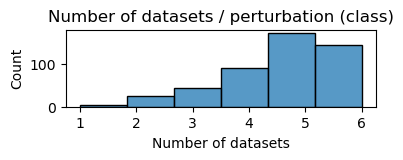

In [3]:
model_set = sc.read(os.path.join(work_dir, 'data', 'eg_full_model_set.h5ad'))
# define all labels to classify on
if 'perturbation_direction' in model_set.obs.columns:
    logging.info('Using perturbation direction to classify')
    cls_labels = ['perturbation_direction', 'perturbation']
else:
    cls_labels = ['celltype', 'perturbation_type', 'perturbation']
likelihood = 'zinb'
# Check number of unique perturbations to classify
logging.info(f'Initializing dataset with {model_set.obs.cls_label.nunique()} classes')
logging.info(f'{model_set.obs[cls_labels[1:]].drop_duplicates().shape[0]} unique perturbations')
logging.info(f'{model_set.obs[cls_labels[-1]].nunique()} unique gene-perturbations')
logging.info(f'{model_set.obs["celltype"].nunique()} unique cell types')
logging.info(f'{model_set.obs["dataset"].nunique()} datasets')
logging.info(f'Mean number of cells / perturbation {model_set.obs.cls_label.value_counts().mean()}')
logging.info(f'Class embedding shape: {model_set.uns["cls_embedding"].shape}')
logging.info(f'Adata shape: {model_set.shape}')
fig = plt.figure(figsize=(4, 1))
ax = sns.histplot(model_set.obs.groupby('perturbation', observed=True).dataset.nunique(), bins=model_set.obs.dataset.nunique())
plt.title('Number of datasets / perturbation (class)')
plt.xlabel('Number of datasets')
plt.show()

In [14]:
# Define covariates, set celltype as covariate
cat_covs = None
cont_covs = None

torch.set_float32_matmul_precision('medium')

# Set logging directory
step_model_dir = os.path.join(model_dir, 'elbo+ckl+con+al')

data_params = {
    'train_size': 0.9,
    'batch_size': None,
    # Set dataloader workers
    'num_workers': 1,
    #'pin_memory': True,
    # Contrastive splitter parameters, cpp * cbp = batch_size
    'max_cells_per_batch': 32,
    'max_classes_per_batch': 32,
    'shuffle_classes': True,
    'use_contrastive_loader': 'train',
}
cls_params = {
    'n_hidden': 0, 'n_layers': 1, 'dropout_rate': 0.1,
    'use_multihead': False, 'use_cosine_similarity': True, 'temperature': 1
}
# Define encoder and decoder parameters
encoder_params = {
    'n_layer': 4,
    # Set attention parameters, set minimum and maximum head dimensions to apply attention to
    'use_attention': True, 'n_head': 8, 'min_attn_dim': 8, 'max_attn_dim': 1024,
    # Other parameters
    'activation_fn': nn.LeakyReLU, 'noise_std': 0.1
}
# No attention in the decoder to get more informative latent dimension
decoder_params = {
    'n_layer': 1, 'use_attention': False, 'activation_fn': nn.LeakyReLU
}

# Set model parameters
jedvae_params = {
    'n_latent': 128,                    # Final projection dimension
    'n_hidden': 1024,
    'dropout_rate': 0.2,
    'dispersion': 'gene',
    'use_batch_norm': 'none',
    'use_layer_norm': 'both',
    'gene_likelihood': 'nb',
    'linear_classifier': True,              # <-- removes need to align latent space to embedding
    'classifier_parameters': cls_params,
    'log_variational': True,
    'l1_lambda': 0,
    'l2_lambda': 0,
    'l_mask': ['attn', 'Attention', 'class_projection'],
    'cls_weight_method': None,
    # Define classification loss strategy
    'classification_loss_strategy': 'kl',
    'focal_gamma': 1.0,
    # Temperature for contrastive loss
    'contrastive_temperature': 0.2,
    # Define reductions
    'reduction': 'sum',
    'non_elbo_reduction': 'sum',
    # Give extra encoder and decoder parameters
    'extra_encoder_kwargs': encoder_params,
    'extra_decoder_kwargs': decoder_params,
    # Randomly mask features to let model learn to deal with missing features
    'use_feature_mask': True,
    'drop_prob': 1e-6
}
# Set max epochs
max_epochs = 400
n_stall = 0
anneal_schedules = {
    'classification_ratio': {'schedule': 'sigmoid', 'anneal_k': 10, 'n_epochs_stall': n_stall, 'min_weight': 1, 'max_weight': 1},
    'contrastive_loss_weight': {'schedule': 'sigmoid', 'anneal_k': 10, 'n_epochs_stall': n_stall, 'min_weight': 1, 'max_weight': 1},
    'alignment_loss_weight': {'schedule': 'sigmoid', 'anneal_k': 10, 'n_epochs_stall': n_stall, 'min_weight': 0, 'max_weight': 0},
    # Should be at least 0.2 to work properly
    'class_kl_temperature': {'schedule': 'sigmoid', 'anneal_k': 10, 'n_epochs_stall': 0, 'min_weight': 0.1, 'max_weight': 0.1},
}
# Set training plan parameters
plan_params = {
    'lr': 1e-4,
    'lr_patience': 30,
    'weight_decay': 1e-5,
    # Use full or fixed class embedding, incl_n_unseen regulates how many unseen to include if mode = "sample"
    'cls_emb_mode': 'full',
    'incl_n_unseen': None,
    # KL and annealing options
    'n_epochs_warmup': max_epochs,
    'min_kl_weight': 0,
    'max_kl_weight': 1,
    # Scaling for class similarities
    'target_scale': 4.0,
    'anneal_schedules': anneal_schedules,
    # Use posterior mean for classification instead of sampled z (should help generalization)
    'use_posterior_mean': 'val',
    'lr_scheduler_metric': 'validation_loss',
    'log_class_distribution': False,
    'full_val_log_every_n_epoch': 10,
    'plot_umap': None
}
# Set training params
train_params = {
    'max_epochs': max_epochs,
    'early_stopping': False,
    'early_stopping_monitor': 'validation_loss',
    'early_stopping_patience': 30,
    'check_val_every_n_epoch': 1,
    'plan_kwargs': plan_params,
    'logger': pl.loggers.TensorBoardLogger(step_model_dir)
}

In [15]:
pretrained = 'base_model' in locals()
if not pretrained:
    logging.info('Setting up model w/o pretraining.')
    # Setup anndata with model
    JEDVI.setup_anndata(
        model_set, batch_key=batch_key, labels_key=cls_label
    )
    jedvae = JEDVI(model_set, **jedvae_params.copy())
else:
    logging.info('Setting up model with pretrained scvi model.')
    jedvae = JEDVI.from_base_model(
        base_model, labels_key=cls_label, **jedvae_params.copy()
    )
# Check number of parameters for model
logging.info(f'# Parameters: {sum([p.numel() for p in jedvae.module.parameters()])}')
jedvae

2025-09-05 13:30:38,859 - INFO - Setting up model w/o pretraining.
2025-09-05 13:30:38,871 - INFO - Class embedding has already been initialized with <class 'src.models._jedvi.JEDVI'> for this adata.
2025-09-05 13:30:39,635 - INFO - # Parameters: 79555838


<class 'src.models._jedvi.JEDVI'> Model with the following params: 
n_classes: 475, n_unseen_classes: 1951
Training status: Not Trained

In [16]:
# Train the model
logging.info(f'Running at: {step_model_dir}')
runner = jedvae.train(data_params=data_params.copy(), model_params=jedvae_params.copy(), train_params=train_params.copy(), return_runner=True)
runner()
# Save results to lightning directory
results, latent = get_model_results(
    model=jedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True, max_classes=100
)

2025-09-05 13:30:39,643 - INFO - Running at: /home/xlv0877/proj_home/dl/models/eg/elbo+ckl+con+al
2025-09-05 13:30:39,643 - INFO - Epochs suggested: 55, training for 400 epochs.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `Data

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
2025-09-05 14:23:26,939 - INFO - Processing train set
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
2025-09-05 14:24:24,796 - INFO - Calculating latent neighbors
Traceback (most recent call last):
  File "/home/xlv0877/.conda/envs/pydl/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/xlv0877/.conda/envs/pydl/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/home/xlv0877/.conda/envs/pydl/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
2025-09-05 14:24:42,996 - INFO - Calculating latent umap
2025-09-05 14:28:11,204 - INFO - Plotting train for label: perturbation_direction
... storing 'cls_prediction' as categorical
/home/xlv08